# **Libraries and Dataset**

In [1]:
import numpy as np
import pandas as pd
import seaborn  as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler,MinMaxScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay

In [2]:
dataset = pd.read_csv('data/market_cluster.csv', encoding='latin1')


In [3]:
dataset.head()

,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State,profit_margin,Cluster
0,OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu,0.32,Medium
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu,0.20,Medium
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu,0.07,Low
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.60,Tamil Nadu,0.10,Low
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu,0.39,High


In [4]:
dataset = pd.DataFrame(dataset)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       9994 non-null   object 
 1   Customer Name  9994 non-null   object 
 2   Category       9994 non-null   object 
 3   Sub Category   9994 non-null   object 
 4   City           9994 non-null   object 
 5   Order Date     9994 non-null   object 
 6   Region         9994 non-null   object 
 7   Sales          9994 non-null   int64  
 8   Discount       9994 non-null   float64
 9   Profit         9994 non-null   float64
 10  State          9994 non-null   object 
 11  profit_margin  9994 non-null   float64
 12  Cluster        9994 non-null   object 
dtypes: float64(3), int64(1), object(9)
memory usage: 1015.1+ KB


# **Data Cleaning & Preprocessing**

In [6]:
dataset.drop(['Order ID'], axis=1, inplace=True)

In [7]:
dataset.isna().sum()

Customer Name    0
Category         0
Sub Category     0
City             0
Order Date       0
Region           0
Sales            0
Discount         0
Profit           0
State            0
profit_margin    0
Cluster          0
dtype: int64

In [8]:
dataset.dropna(inplace=True)

In [9]:
def remove_outliers(data: pd.DataFrame, column: str) -> pd.Series:
    q3, q1 = np.nanpercentile(data[column], [75, 25])
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    data = data[(data[column] > lower_bound) & (data[column] < upper_bound)]

    return data

dataset = remove_outliers(dataset, 'Discount')
dataset = remove_outliers(dataset, 'Sales')
dataset = remove_outliers(dataset, 'Profit')

In [10]:
dataset.head()

,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State,profit_margin,Cluster
0,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu,0.32,Medium
1,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu,0.20,Medium
2,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu,0.07,Low
3,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.60,Tamil Nadu,0.10,Low
4,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu,0.39,High


<AxesSubplot:xlabel='Cluster', ylabel='Count'>

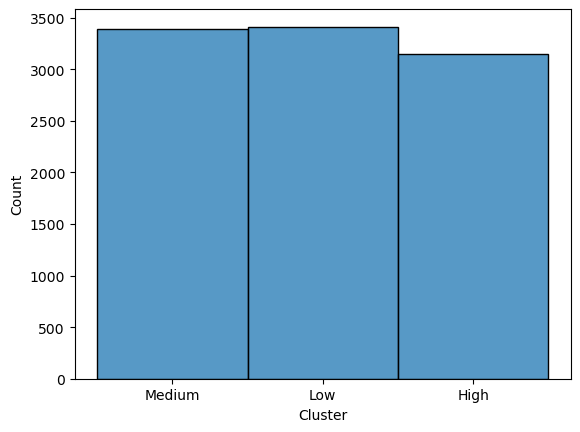

In [11]:
sns.histplot(dataset['Cluster'])

In [12]:
encoder = LabelEncoder()
scaler = StandardScaler()
onehot = OneHotEncoder()
minmaxscaler = MinMaxScaler()

In [13]:
# dataset["Order Date"] = pd.to_datetime(dataset["Order Date"])
# dataset["Order Date"] = dataset["Order Date"].dt.month
# dataset["Customer Name"] = encoder.fit_transform(dataset["Customer Name"])
# dataset["Category"] = encoder.fit_transform(dataset["Category"])
# dataset["City"] = encoder.fit_transform(dataset["City"])
# dataset["Region"] = encoder.fit_transform(dataset["Region"])
# dataset["State"] = encoder.fit_transform(dataset["State"])
# dataset["Sub Category"] = encoder.fit_transform(dataset["Sub Category"])

dataset["Order Date"] = pd.to_datetime(dataset["Order Date"])
dataset["Order Date"] = dataset["Order Date"].dt.month
dataset["Customer Name"] = onehot.fit_transform(dataset["Customer Name"].values.reshape(-1, 1)).toarray()
dataset["Category"] = onehot.fit_transform(dataset["Category"].values.reshape(-1, 1)).toarray()
dataset["City"] = onehot.fit_transform(dataset["City"].values.reshape(-1, 1)).toarray()
dataset["Region"] = onehot.fit_transform(dataset["Region"].values.reshape(-1, 1)).toarray()
dataset["State"] = onehot.fit_transform(dataset["State"].values.reshape(-1, 1)).toarray()
dataset["Sub Category"] = onehot.fit_transform(dataset["Sub Category"].values.reshape(-1, 1)).toarray()
dataset["Order Date"] = encoder.fit_transform(dataset["Order Date"])

In [14]:
dataset[["Sales", "Discount", "profit_margin"]] = scaler.fit_transform(dataset[["Sales", "Discount", "profit_margin"]])
dataset["Profit"] = minmaxscaler.fit_transform(dataset["Profit"].values.reshape(-1, 1))

In [15]:
class_to_numeric = {'Low': 0, 'Medium': 1, 'High': 2}
dataset['Cluster'] = [class_to_numeric[label] for label in dataset['Cluster']]

In [16]:
dataset.head()

,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State,profit_margin,Cluster
0,0.0,0.0,0.0,0.0,10,0.0,-0.414559,-1.430908,0.369225,1.0,0.595874,1
1,0.0,0.0,0.0,0.0,10,0.0,-1.291968,-0.627370,0.122296,1.0,-0.416872,1
2,0.0,0.0,1.0,0.0,5,0.0,1.507054,-0.225601,0.137417,1.0,-1.514014,0
3,0.0,0.0,0.0,0.0,9,0.0,-1.036563,0.310092,0.063185,1.0,-1.260827,0
4,0.0,0.0,0.0,0.0,9,0.0,1.498367,0.444015,0.877036,1.0,1.186643,2


# **Split Data and Encoder**

In [17]:
X = dataset.drop(['Cluster','Sub Category','State','Profit','profit_margin'],axis=1)
y = dataset['Profit']

In [18]:
X.head()


,Customer Name,Category,City,Order Date,Region,Sales,Discount
0,0.0,0.0,0.0,10,0.0,-0.414559,-1.430908
1,0.0,0.0,0.0,10,0.0,-1.291968,-0.627370
2,0.0,0.0,0.0,5,0.0,1.507054,-0.225601
3,0.0,0.0,0.0,9,0.0,-1.036563,0.310092
4,0.0,0.0,0.0,9,0.0,1.498367,0.444015


In [19]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

<AxesSubplot:>

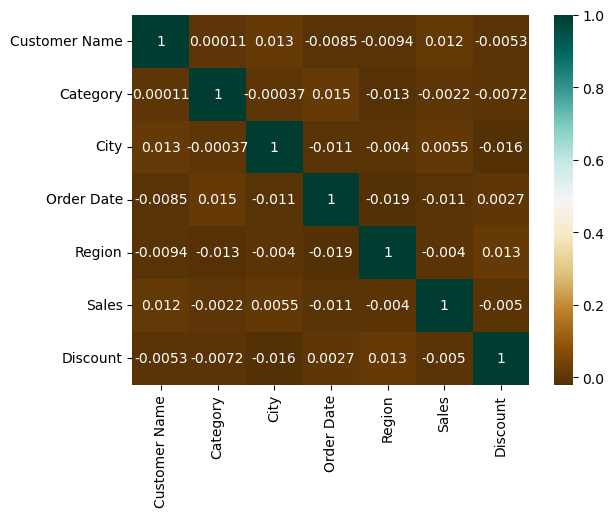

In [20]:
heatcol = X.corr()
sns.heatmap(heatcol,cmap="BrBG",annot=True)

In [21]:
print("Dimension of Train set",X_train.shape)
print("Dimension of Val set",X_val.shape)
print("Dimension of Test set",X_test.shape,"\n")

num_cols = X_train._get_numeric_data().columns
print("Number of numeric features:",num_cols.size)

Dimension of Train set (7960, 7)
Dimension of Val set (995, 7)
Dimension of Test set (996, 7) 

Number of numeric features: 7


# **ANNr**

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from scikeras.wrappers import KerasRegressor

In [23]:
def create_model(units=64, optimizer='adam', loss='mae'):
    model = Sequential()
    model.add(Flatten(input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units, activation='relu'))
    model.compile(optimizer=optimizer, loss=loss, metrics=['mean_absolute_error'])
    
    return model

In [24]:
model = KerasRegressor(build_fn=create_model, units=32, epochs=100, batch_size=32, verbose=0)

param_grid = {
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'units': [32, 64, 128],
    'loss' : ['mae', 'mse']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='accuracy')
grid_result = grid.fit(X_train, y_train)

c:\Users\Asus\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Asus\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Asus\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "c:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  

In [25]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: nan using {'loss': 'mae', 'optimizer': 'adam', 'units': 32}


In [26]:
optimizer = grid_result.best_params_['optimizer']
units = grid_result.best_params_['units']
loss = grid_result.best_params_['loss']

In [27]:
model = Sequential()
model.add(Flatten(input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

model.compile(optimizer=optimizer, loss=loss, metrics=['mean_absolute_error'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Data: {loss}')

Epoch 1/100
249/249 [==============================] - 2s 5ms/step - loss: 3.6774 - mean_absolute_error: 3.6774 - val_loss: 2.6898 - val_mean_absolute_error: 2.6898
Epoch 2/100
249/249 [==============================] - 1s 3ms/step - loss: 1.8408 - mean_absolute_error: 1.8408 - val_loss: 1.0650 - val_mean_absolute_error: 1.0650
Epoch 3/100
249/249 [==============================] - 1s 3ms/step - loss: 0.6696 - mean_absolute_error: 0.6696 - val_loss: 0.4762 - val_mean_absolute_error: 0.4762
Epoch 4/100
249/249 [==============================] - 1s 3ms/step - loss: 0.4097 - mean_absolute_error: 0.4097 - val_loss: 0.3599 - val_mean_absolute_error: 0.3599
Epoch 5/100
249/249 [==============================] - 1s 3ms/step - loss: 0.3148 - mean_absolute_error: 0.3148 - val_loss: 0.2847 - val_mean_absolute_error: 0.2847
Epoch 6/100
249/249 [==============================] - 1s 3ms/step - loss: 0.2505 - mean_absolute_error: 0.2505 - val_loss: 0.2327 - val_mean_absolute_error: 0.2327
Epoch 7/10

In [28]:
from tensorflow.keras.utils import plot_model
model.summary()
plot_model(model, to_file='mlp-mnist.png', show_shapes=True)

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_37 (Flatten)        (None, 7)                 0         
                                                                 
 dense_37 (Dense)            (None, 1)                 8         
                                                                 
Total params: 8 (32.00 Byte)
Trainable params: 8 (32.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


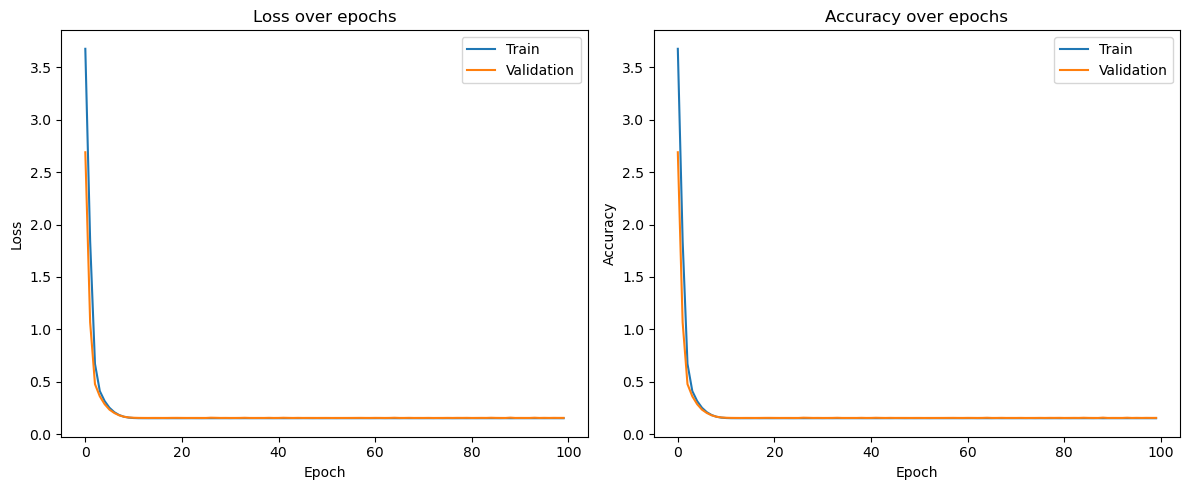

In [29]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')

plt.tight_layout()
plt.show()


In [30]:
y_test = y_test.values.reshape(-1, 1)

In [31]:
predictions_scaled = model.predict(X_test)
y_pred = minmaxscaler.inverse_transform(predictions_scaled)
y_test = minmaxscaler.inverse_transform(y_test)

32/32 [==============================] - 0s 2ms/step


In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse} \n')
print(f'R-squared: {r2}')
print(f'accuracy : {r2}')

Mean Squared Error: 34846.30788069707
Mean Absolute Error: 150.61522602004698
Root Mean Squared Error: 186.67165794704098 

R-squared: 0.31784799180399526
accuracy : 0.31784799180399526


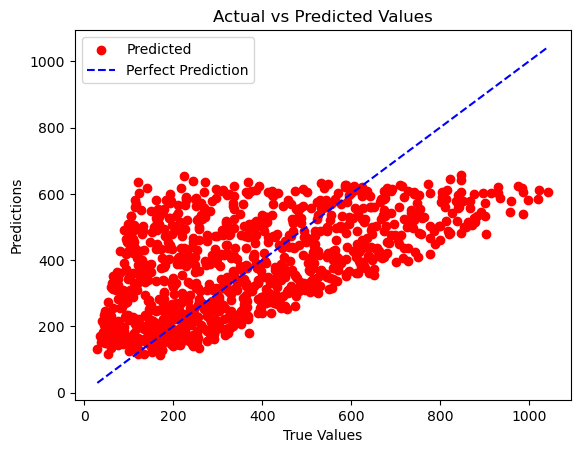

In [33]:
plt.scatter(y_test, y_pred, label="Predicted", color='red')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='blue', label='Perfect Prediction')  # Adding a line for perfect prediction
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()

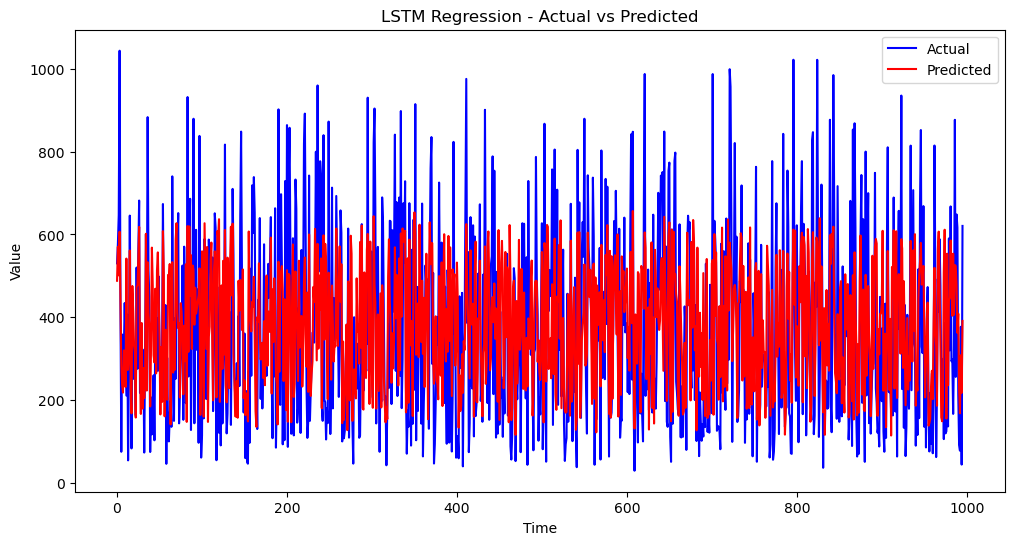

In [34]:
# Visualisasi
plt.figure(figsize=(12, 6))

# Plot nilai sebenarnya
plt.plot(y_test, label='Actual', color='blue')

# Plot prediksi
plt.plot(y_pred, label='Predicted', color='red')

plt.title('LSTM Regression - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

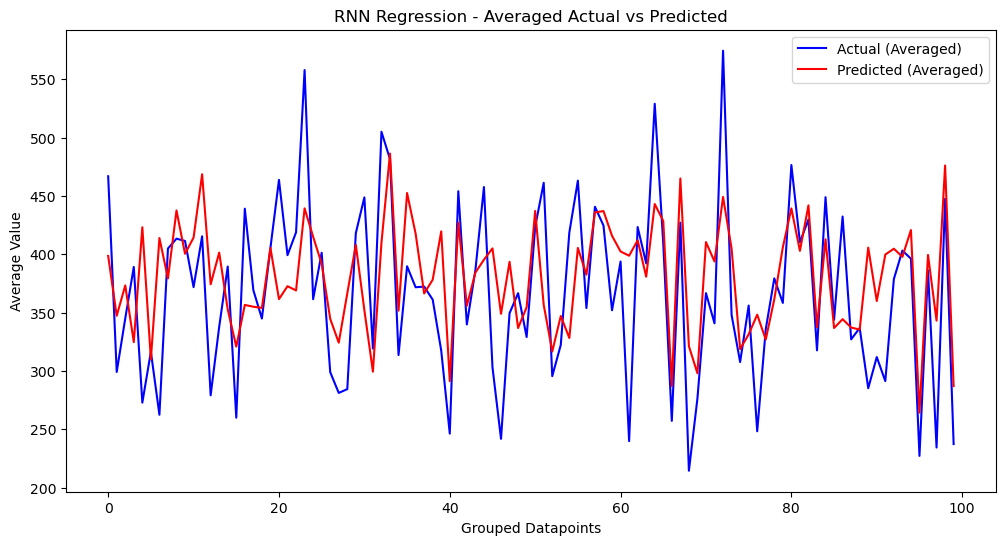

In [35]:
# Grouping and averaging 'y_test' and 'y_pred' values
group_size = 10  # Define the size of each group
averaged_y_test = [np.mean(y_test[i:i + group_size]) for i in range(0, len(y_test), group_size)]
averaged_y_pred = [np.mean(y_pred[i:i + group_size]) for i in range(0, len(y_pred), group_size)]

# Plotting the averaged values
plt.figure(figsize=(12, 6))
plt.plot(averaged_y_test, label='Actual (Averaged)', color='blue')
plt.plot(averaged_y_pred, label='Predicted (Averaged)', color='red')

plt.title('RNN Regression - Averaged Actual vs Predicted')
plt.xlabel('Grouped Datapoints')
plt.ylabel('Average Value')
plt.legend()
plt.show()